In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%matplotlib inline

# Modelling Binary and Triple Star Systems

Stellar systems are governed by Newton's laws of motion. From Newton's laws, we can derive the Ordinary Differential Equations (ODEs) that determine the orbital trajectories of the bodies in the system. The goal of this notebook is to solve these equations to model the following three scenarios in **two dimensions**:<br>
1. A two-body system made up of two stars with a mass ratio 1:2 undergoing multiple stable orbits. <br><br> For N stars in the system, the ODE for the x-position of each star is:<br><br> $$\frac{d^2 x_i}{dt^2} = \sum_{\substack{j=1 \\ j \neq i}}^{j=N} \frac{GM_j}{r_{ij}^2} \cos(\theta)$$ Similarly, the ODE for the y-position is: $$\frac{d^2 y_i}{dt^2} = \sum_{\substack{j=1 \\ j \neq i}}^{j=N} \frac{GM_j}{r_{ij}^2} \sin(\theta)$$ where

- $r_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$
- $\cos \theta = \frac{(x_j - x_i)}{r_{ij}}$
- $\sin \theta = \frac{(y_j - y_i)}{r_{ij}}$

2. The stable solution of a three-body system that was discovered by Cris Moore and proved by Chenciner and Montgomery, described [here](https://arxiv.org/abs/math/0011268). The 3 stars have equal mass and are assumed to be point-like objects which cannot collide. Needless to say, such a system has not yet been observed in nature. For the vast majority of cases, three-star systems consist of two stars closely orbiting each other with the third star orbiting the binary pair at a much larger distance.

3. A chaotic solution of a three-body system where one star gets ejected from the system.

We will be using numerical integration methods to solve the ODEs. The first method involves the use of the **solve_ivp()** function which, by default, uses the Runge-Kutta numerical technique of order 4 and 5 to find the solution. The second is the **Midpoint** method which is a second-order method that is very similar to Euler's method but includes an additional step where the slope at the midpoint is calculated and used to estimate the value at the next step.<br>

Throughout the notebook we will be working with order-1 numbers to simplify the calculations. We will set the gravitational constant G = 1 to non-dimensionalise the problem. The masses, positions and velocities of the stars will be of order 1.

The class **<font color=red>Star</font>** creates a star object which has as attributes a **mass**, **initial positions** and **velocities** in the x and y directions. For a star object named star_1, its mass can be altered using the method **star_1.mass** = new value

In [2]:
class Star:
    
    """
    Represents a star.
    
    Attributes: mass, initial_x_position, initial_x_velocity, initial_y_position, initial_y_velocity
    
    """
    
    def __init__(self, mass=1, initial_x_position=0, initial_x_velocity=0, initial_y_position=0, initial_y_velocity=0):
        
        self.mass = mass
        
        assert self.mass > 0, "The mass must be greater than zero"   # Ensures the star does not have zero mass
        
        self.initial_x_position = initial_x_position
        self.initial_x_velocity = initial_x_velocity
        self.initial_y_position = initial_y_position
        self.initial_y_velocity = initial_y_velocity
        
        self._initial_values = np.array([self.initial_x_position, self.initial_x_velocity,
                                         self.initial_y_position, self.initial_y_velocity])
        
    @property   # This is a getter method which allows the user to access the mass attribute
    
    def mass(self):
        return self._mass
    
    @property
    def initial_values(self):
        return self._initial_values
    
    @mass.setter   # This setter method allows the user to set a value for the mass attribute
    def mass(self, value):
        
        assert value > 0, "The mass must be greater than zero"
        self._mass = value
        
    @initial_values.setter
    def initial_values(self, values):
        
        if len(values) == len(self._initial_values):
            self._initial_values = np.array(values)
        else:
            raise ValueError("Invalid number of initial values. Must provide exactly 4 values.")

Tests for the Star class:

In [3]:
a_star = Star()

# a_star.mass = 0   # this should raise an error

# a_star.initial_values = [1,2,3]   # this should raise an error

To demonstrate class inheritance, a class named **<font color=red>NStarSystem</font>** was created which takes in a list of stars to initiate an instance of the class. The classes for binary and triple star systems will inherit the gravitational constant (which is set to 1.0 in the simulations) and the initial values setter function from the NStarSystem class.

In [4]:
class NStarSystem:
    
    """
    Represents a star system containing N stars.
    
    Class attribute: G
    
    Instance attributes: stars
    
    """
    
    G = 1.0   # The gravitational constant
    
    def __init__(self, stars):
        
        if all(isinstance(star, Star) for star in stars):
            
            self.stars = stars
            self._initial_values = np.concatenate([star._initial_values for star in stars])
            self._ODE_solved = False   # Initially the ODE of the system is unsolved
            
        else:   # Ensures only a list of stars can produce an object of the class NStarSystem
            
            raise TypeError("Only lists containing objects of the class Star are accepted.")
            
    @property
    def initial_values(self):
        return self._initial_values

    @initial_values.setter
    def initial_values(self, values):
        if len(values) == len(self.initial_values):
            self._initial_values = np.array(values)
        else:
            raise ValueError(f"Invalid number of initial values. Must provide exactly {len(self._initial_values)} values.")

Tests for NStarSystem class:

In [5]:
a_star_system = NStarSystem([a_star])

# a_star_system = NStarSystem(["a star"])   # should raise an error

The **<font color=red>BinaryStarSystem</font>** class solves the four ordinary differential equations that describe the motion of two stars in a binary system in the x-y plane, thereby obtaining values for the positions of the two stars in the x and y directions which can then be used to plot the orbital trajectories of the two stars.

In [6]:
class BinaryStarSystem(NStarSystem):
    
    """
    Represents a binary star system. This class inherits the getter and setter methods for the initial values
    from the class NStarSystem.
    
    Class attribute: G
    
    Instance attributes: first_star, second_star
    
    Methods: calculate_dydt, calculate_ODE_solution, calculate_ODE_solution_using_midpoint, plot_solution,
    plot_phase_plot
    
    """
    
    def __init__(self, first_star, second_star):
        
        super().__init__([first_star, second_star])
        
        # Initialising lists that will be updated with the ODEs solutions
        
        self._solution_t = []
        self._solution_x1 = []
        self._solution_v_x1 = []
        self._solution_y1 = []
        self._solution_v_y1 = []
        self._solution_x2 = []
        self._solution_v_x2 = []
        self._solution_y2 = []
        self._solution_v_y2 = []
         
    def calculate_dydt(self, t, y):
        
        """Returns an array containing differential equations."""
        
        x1 = y[0]   # the x-position of the first star
        v_x1 = y[1]
        y1 = y[2]
        v_y1 = y[3]
        x2 = y[4]
        v_x2 = y[5]
        y2 = y[6]
        v_y2 = y[7]
    
        dydt = np.zeros_like(y)   # Sets up dydt so that it has same dimensions as the array y
        
        dydt[0] = v_x1
        dydt[1] = self.G * self.stars[1]._mass * (x2-x1)/(((x1-x2)**2 + (y1-y2)**2)**0.5)**3
        
        dydt[2] = v_y1
        dydt[3] = self.G * self.stars[1]._mass * (y2-y1)/(((x1-x2)**2 + (y1-y2)**2)**0.5)**3
        
        dydt[4] = v_x2
        dydt[5] = self.G * self.stars[0]._mass * (x1-x2)/(((x1-x2)**2 + (y1-y2)**2)**0.5)**3
        
        dydt[6] = v_y2
        dydt[7] = self.G * self.stars[0]._mass * (y1-y2)/(((x1-x2)**2 + (y1-y2)**2)**0.5)**3
        
        return dydt
    
    
    def calculate_ODE_solution(self, initial_values = None, max_time = 100, N_time_steps = 100, rtol = 1e-3):
        
        """Computes solutions for ordinary differential equations using solve_ivp()."""
        
        if initial_values is None:
            
            initial_values = self._initial_values   # Takes the initial values of the stars if no values for
                                                    # the initial conditions are entered.
            
        t_solution = np.linspace(0.0, max_time, N_time_steps+1)
        
        ODE_solution = solve_ivp(self.calculate_dydt, [0, max_time], initial_values, t_eval = t_solution, rtol=rtol)
        
        # Updates the lists of solutions for each variable with the solution at each time step.
        
        self._solution_t = ODE_solution.t
        
        self._solution_x1 = ODE_solution.y[0]
        self._solution_v_x1 = ODE_solution.y[1]
        self._solution_y1 = ODE_solution.y[2]
        self._solution_v_y1 = ODE_solution.y[3]
        self._solution_x2 = ODE_solution.y[4]
        self._solution_v_x2 = ODE_solution.y[5]
        self._solution_y2 = ODE_solution.y[6]
        self._solution_v_y2 = ODE_solution.y[7]
        
        self._ODE_solved = True
        
    def calculate_ODE_solution_using_midpoint(self, initial_values = None, max_time = 100, N_time_steps = 100):     
        
        """Computes solutions for ordinary differential equations using the midpoint method."""     
        
        if initial_values is None:
            
            initial_values = self._initial_values  
        
        t_solution = np.linspace(0.0, max_time, N_time_steps+1)
        delta_t = max_time / N_time_steps
        
        y_solution = np.zeros((N_time_steps+1, len(initial_values)))   # Initialises the array y_solutions to have the
        # same number of columns as the number of initial values for the star system, and a number of rows
        # equal to N_time_steps + 1
        
        for i, time in enumerate(t_solution):
            
            if i == 0:
                
                y_solution[i] = initial_values   # At time t=0 the initial values of the system are entered.
                old_time = time
                
            else:
                
                dydt_at_t = self.calculate_dydt(old_time, y_solution[i-1])
                
                y_t_plus_half = (y_solution[i-1] + 0.5 * dydt_at_t * delta_t)
                
                t_plus_half = old_time + 0.5 * delta_t
                
                dydt_at_t_plus_half = self.calculate_dydt(t_plus_half, y_t_plus_half) # dydt calculated at the midpoint
                
                y_solution[i] = (y_solution[i-1] + dydt_at_t_plus_half * delta_t)
                
                old_time = time
        
        self._solution_t = t_solution
        
        # The lists of solutions are filled with the values in the columns corresponding to each of the 8 variables.
        
        self._solution_x1 = y_solution[:,0]
        self._solution_v_x1 = y_solution[:,1]
        self._solution_y1 = y_solution[:,2]
        self._solution_v_y1 = y_solution[:,3]
        self._solution_x2 = y_solution[:,4]
        self._solution_v_x2 = y_solution[:,5]
        self._solution_y2 = y_solution[:,6]
        self._solution_v_y2 = y_solution[:,7]
        
        self._ODE_solved = True
        
    def plot_solution(self) :
        
        """Plots the trajectories in the x-y plane of each star."""
        
        assert self._ODE_solved, "Solution has not been computed"
        
        plt.figure()
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("y") 
        plt.plot(self._solution_x1, self._solution_y1,'r-', label="star 1")
        plt.plot(self._solution_x2, self._solution_y2,'b-', label="star 2")
        plt.legend()
        
    def plot_phase_plot(self) :
        
        """Creates a phase diagram of the y-position and y-velocity for each star."""
        
        assert self._ODE_solved, "Solution has not been computed"
        
        plt.figure()
        plt.grid()
        plt.xlabel("y")
        plt.ylabel("v_y") 
        plt.plot(self._solution_y1, self._solution_v_y1, "r-", label = "star 1")
        plt.plot(self._solution_y2, self._solution_v_y2, "b-", label = "star 2")
        plt.legend()

Tests for BinaryStarSystem class:

In [7]:
star_1 = Star(mass=1, initial_x_position=1, initial_x_velocity=0, initial_y_position=0, initial_y_velocity=1)
star_2 = Star(mass=2, initial_x_position= -1, initial_x_velocity=0, initial_y_position=0, initial_y_velocity= -0.5)

binary_system = BinaryStarSystem(star_1, star_2)

# binary_system = BinaryStarSystem(star_1)   # should raise an error

binary_system.initial_values = np.array([1,0,0,1,-1,0,0,-0.5])

# binary_system.initial_values = np.array([5,5,5])   # should raise an error

Plotting the orbits of two stars:

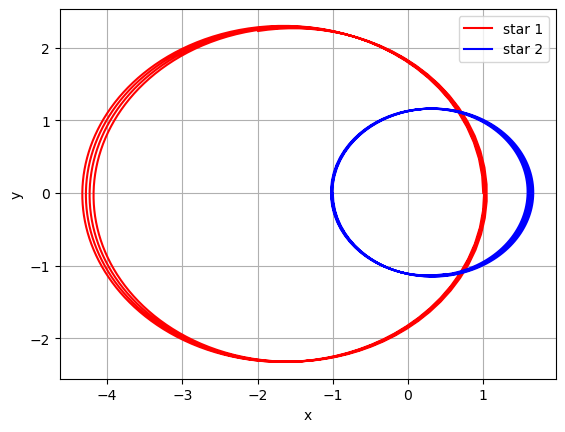

In [8]:
binary_system.calculate_ODE_solution(max_time = 120, N_time_steps = 500)
binary_system.plot_solution()

Plotting the orbits of the two stars after reducing the value of the **rtol** parameter to 1e-6. rtol is the relative error tolerance in the **solve_ivp()** function. solve_ivp() calculates the solution error, and if it is greater than the value of rtol it increases the steps to reduce the error. Therefore a smaller rtol leads to more accurate results.

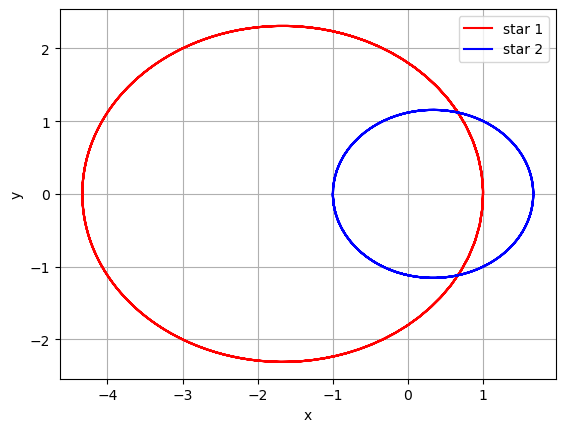

In [9]:
binary_system.calculate_ODE_solution(max_time = 120, N_time_steps = 500, rtol = 1e-6)
binary_system.plot_solution()

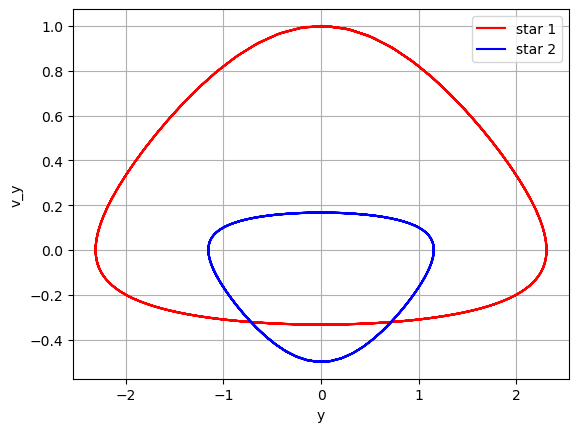

In [10]:
binary_system.plot_phase_plot()

Plotting the orbits after computing the solution using the midpoint method. Increasing the steps leads to better accuracy.

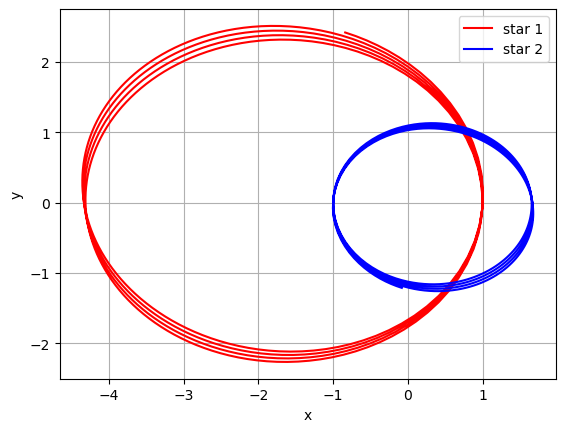

In [11]:
binary_system.calculate_ODE_solution_using_midpoint(max_time = 120, N_time_steps = 500)
binary_system.plot_solution()

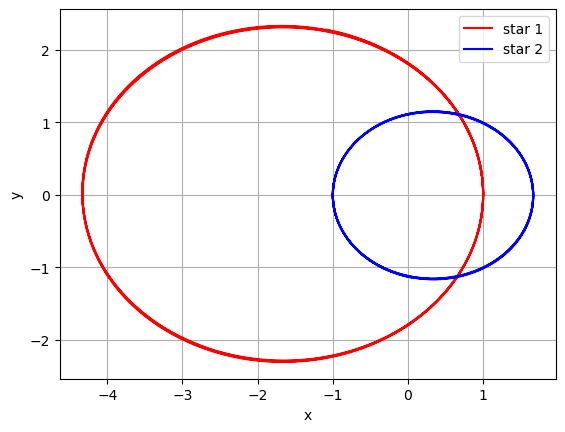

In [12]:
binary_system.calculate_ODE_solution_using_midpoint(max_time = 120, N_time_steps = 1500)
binary_system.plot_solution()

Next we create a class for a triple star system:

In [13]:
class TripleStarSystem(NStarSystem):
    
    """
    Represents a triple star system. This class inherits the getter and setter methods for the initial values
    from the class NStarSystem.
    
    Class attribute: G
    
    Instance attributes: first_star, second_star, third_star
    
    Methods: calculate_dydt, calculate_ODE_solution, plot_solution, plot_phase_plot
    
    """
    
    def __init__(self, first_star, second_star, third_star):
        
        super().__init__([first_star, second_star, third_star])
        
        self._solution_t = []
        self._solution_x1 = []
        self._solution_v_x1 = []
        self._solution_y1 = []
        self._solution_v_y1 = []
        self._solution_x2 = []
        self._solution_v_x2 = []
        self._solution_y2 = []
        self._solution_v_y2 = []
        self._solution_x3 = []
        self._solution_v_x3 = []
        self._solution_y3 = []
        self._solution_v_y3 = []
    
    def calculate_dydt(self, t, y):
        
        """Returns an array containing differential equations."""      
        
        x1 = y[0]
        v_x1 = y[1]
        y1 = y[2]
        v_y1 = y[3]
        x2 = y[4]
        v_x2 = y[5]
        y2 = y[6]
        v_y2 = y[7]
        x3 = y[8]
        v_x3 = y[9]
        y3 = y[10]
        v_y3 = y[11]
    
        dydt = np.zeros_like(y)
        
        dydt[0] = v_x1
        dydt[1] = self.G * self.stars[1]._mass * (x2-x1)/(((x1-x2)**2 + (y1-y2)**2)**0.5)**3 + self.G * self.stars[2]._mass * (x3-x1)/(((x1-x3)**2 + (y1-y3)**2)**0.5)**3
        
        dydt[2] = v_y1
        dydt[3] = self.G * self.stars[1]._mass * (y2-y1)/(((x1-x2)**2 + (y1-y2)**2)**0.5)**3 + self.G * self.stars[2]._mass * (y3-y1)/(((x1-x3)**2 + (y1-y3)**2)**0.5)**3
        
        dydt[4] = v_x2
        dydt[5] = self.G * self.stars[0]._mass * (x1-x2)/(((x1-x2)**2 + (y1-y2)**2)**0.5)**3 + self.G * self.stars[2]._mass * (x3-x2)/(((x2-x3)**2 + (y2-y3)**2)**0.5)**3
        
        dydt[6] = v_y2
        dydt[7] = self.G * self.stars[0]._mass * (y1-y2)/(((x1-x2)**2 + (y1-y2)**2)**0.5)**3 + self.G * self.stars[2]._mass * (y3-y2)/(((x2-x3)**2 + (y2-y3)**2)**0.5)**3
        
        dydt[8] = v_x3
        dydt[9] = self.G * self.stars[0]._mass * (x1-x3)/(((x1-x3)**2 + (y1-y3)**2)**0.5)**3 + self.G * self.stars[1]._mass * (x2-x3)/(((x2-x3)**2 + (y2-y3)**2)**0.5)**3
        
        dydt[10] = v_y3
        dydt[11] = self.G * self.stars[0]._mass * (y1-y3)/(((x1-x3)**2 + (y1-y3)**2)**0.5)**3 + self.G * self.stars[1]._mass * (y2-y3)/(((x2-x3)**2 + (y2-y3)**2)**0.5)**3
        
        return dydt
    
    def calculate_ODE_solution(self, initial_values = None, max_time = 100, N_time_steps = 100, rtol = 1e-6):
        
        """Computes solutions for ordinary differential equations using solve_ivp()."""
        
        
        if initial_values is None:
            
            initial_values = self._initial_values
            
        t_solution = np.linspace(0.0, max_time, N_time_steps+1)
        ODE_solution = solve_ivp(self.calculate_dydt, [0, max_time], initial_values, t_eval = t_solution, rtol=rtol)
        
        self._solution_t = ODE_solution.t
        
        self._solution_x1 = ODE_solution.y[0]
        self._solution_v_x1 = ODE_solution.y[1]
        self._solution_y1 = ODE_solution.y[2]
        self._solution_v_y1 = ODE_solution.y[3]
        self._solution_x2 = ODE_solution.y[4]
        self._solution_v_x2 = ODE_solution.y[5]
        self._solution_y2 = ODE_solution.y[6]
        self._solution_v_y2 = ODE_solution.y[7]
        self._solution_x3 = ODE_solution.y[8]
        self._solution_v_x3 = ODE_solution.y[9]
        self._solution_y3 = ODE_solution.y[10]
        self._solution_v_y3 = ODE_solution.y[11]
        
        self._ODE_solved = True
      
    def plot_solution(self) :
        
        """Creates a plot of the x and y positions for each star."""
        
        assert self._ODE_solved, "solution has not yet been found"
        
        plt.figure()
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("y") 
        plt.plot(self._solution_x1, self._solution_y1,'r-', label="star 1")
        plt.plot(self._solution_x2, self._solution_y2,'b-', label="star 2")
        plt.plot(self._solution_x3, self._solution_y3,'g-', label="star 3")
        plt.legend()
        
    def plot_phase_plot(self) :
        
        """Creates a phase diagram of the y-position and y-velocity for each star."""
        
        assert self._ODE_solved, "solution has not yet been found"
        
        plt.figure()
        plt.grid()
        plt.xlabel("y")
        plt.ylabel("v_y") 
        plt.plot(self._solution_y1, self._solution_v_y1, "r-", label = "star 1")
        plt.plot(self._solution_y2, self._solution_v_y2, "b-", label = "star 2")
        plt.plot(self._solution_y3, self._solution_v_y3, "g-", label = "star 3")
        plt.legend()

The following is a plot of the trajectories of the stable orbit:

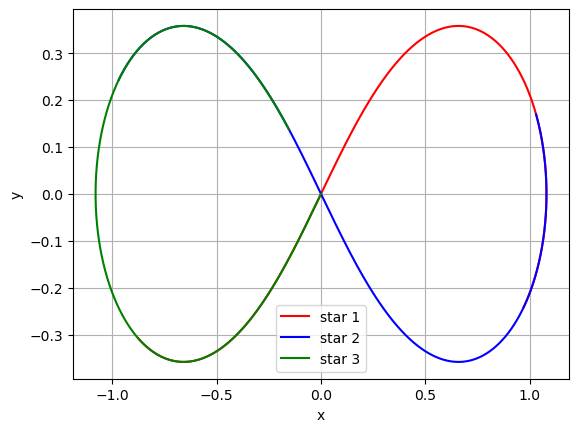

In [14]:
star_1 = Star(1, 0.97000436, 0.93240737 * 0.5, -0.24308753, 0.86473146 * 0.5)
star_2 = Star(1, -0.97000436, 0.93240737 * 0.5, 0.24308753, 0.86473146 * 0.5)
star_3 = Star(1, 0.0, -0.93240737, 0.0, -0.86473146)

triple_system = TripleStarSystem(star_1, star_2, star_3)
triple_system.calculate_ODE_solution(max_time = 3, N_time_steps = 5000)
triple_system.plot_solution()

Next, we plot an unstable scenario where one star gets ejected from the system:

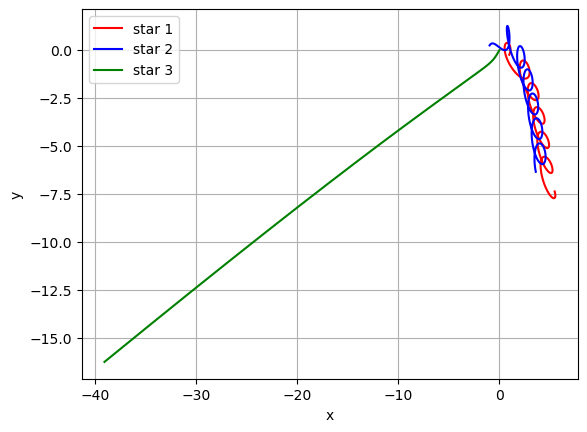

In [15]:
star_1 = Star(1, 0.97000436, 0.93240737 * 0.5, -0.24308753, 0.86473146 * 0.5)
star_2 = Star(1, -0.97000436, 0.93240737 * 0.5, 0.24308753, 0.86473146 * 0.5)
star_3 = Star(1, 0.0, -1.43240737, 0.0, -1.36473146)

triple_system = TripleStarSystem(star_1, star_2, star_3)
triple_system.calculate_ODE_solution(max_time = 60, N_time_steps = 5000)
triple_system.plot_solution()